### This is a notebook for the supplement section on PCA explained variance
Illustrates why we decided to use nonlinear dimensionality reduction methods and manifold learning.

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.config import configurations
import os
from pathlib import Path
from src.dimensionality_reduction import compute_covariance, explained_variance

/mnt/c/Users/rlevin/Documents/notebooks/code/covid-mobility-and-behavior


In [2]:
project_dir = configurations['PROJECT_DIR']
#Check that the directory with the supplement figures exists
Path(os.path.join(project_dir, 'reports', 'figures', 'supplement')).mkdir(parents=True, exist_ok=True)

In [30]:
#Load the covid behavior dataset:
state_names = ['WASHINGTON', 'GEORGIA', 'TEXAS', 'CALIFORNIA']
state
stayathome_states = [pd.read_csv(configurations[i+'_RAW_DATA_PATH'], index_col = 'Unnamed: 0').dropna() for i in state_names]
stayathome_states = [state[state.columns[:117]] for state in stayathome_states] #Take the first 117 days

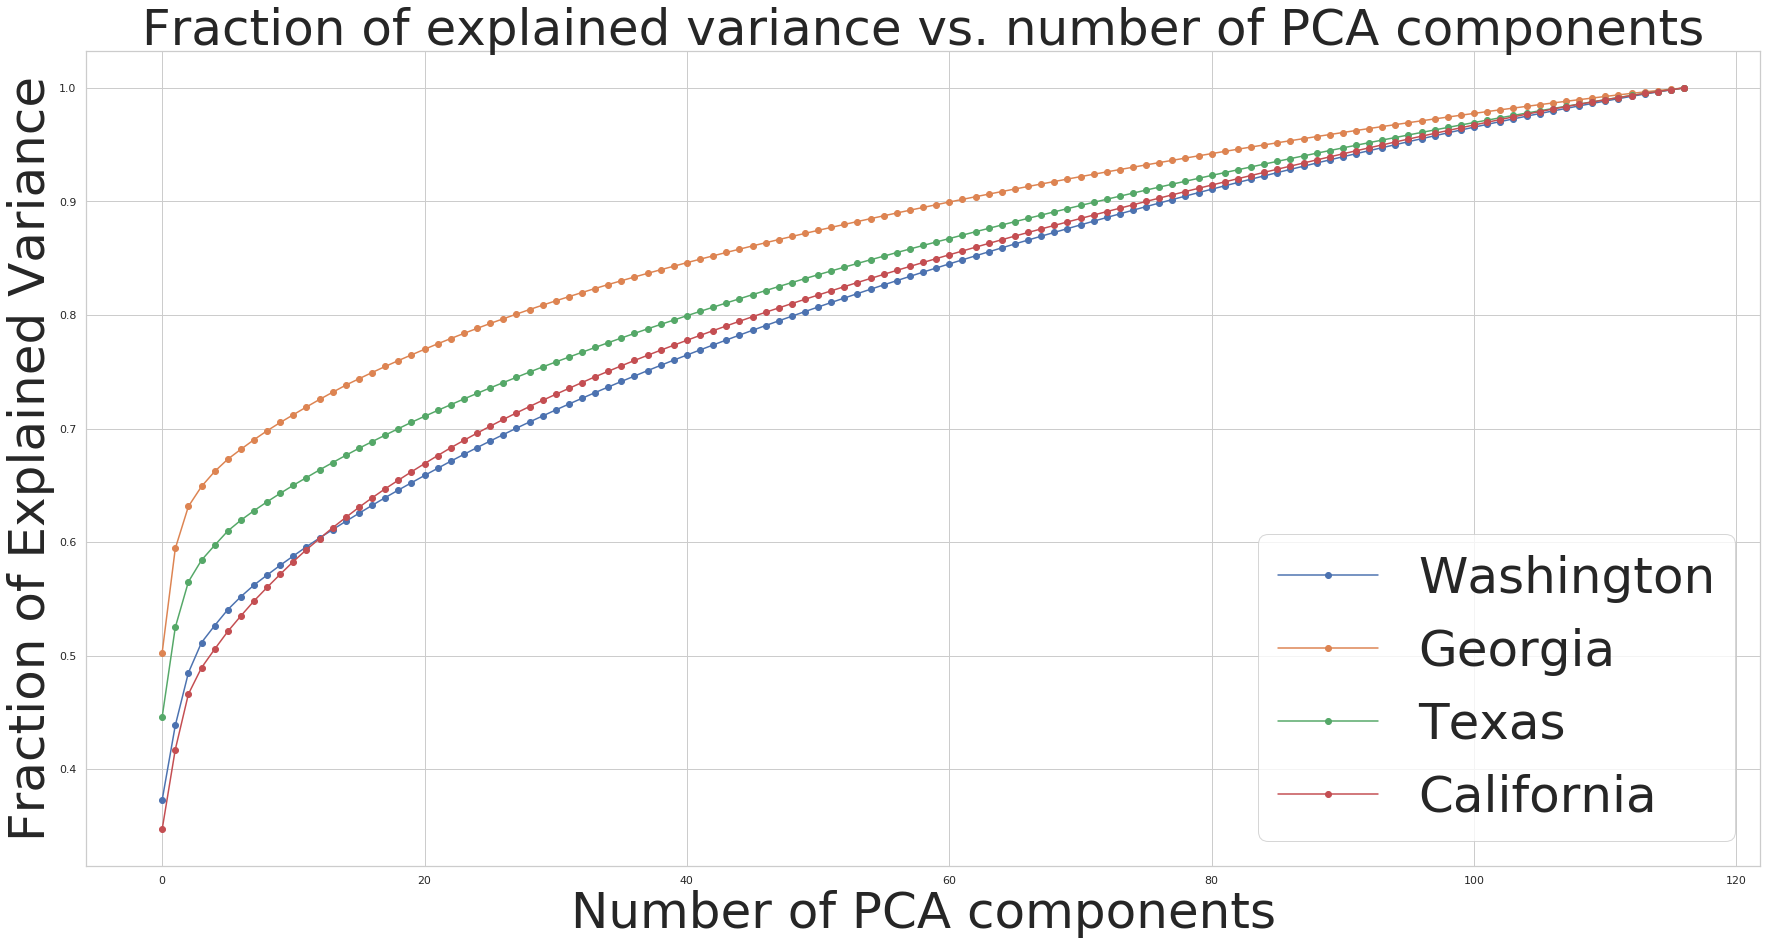

In [29]:
#Look at the fraction of explained variance
#Suggest that maybe a linear dimensionality reduction is not perfect in this case
fs = 10
enlarge =  5
sns.set(style="whitegrid")
plt.figure(figsize = (enlarge*6,enlarge*3))
for i, state in enumerate(stayathome_states):
    plt.plot(explained_variance(state), '-o', label = state_names[i].title())
plt.title('Fraction of explained variance vs. number of PCA components', fontsize = enlarge*fs)
plt.ylabel('Fraction of Explained Variance', fontsize = enlarge*fs)
plt.xlabel('Number of PCA components', fontsize = enlarge*fs)
plt.legend(fontsize = enlarge*fs)
plt.savefig(os.path.join(configurations['FIGURE_PATH'], 'supplement', 'PCA_explained_variance.pdf'))